# **PROJECT IDS 561: SENTIMENTAL ANALYSIS OF YELP REVIEWS**

**LINKING THE COLAB TO GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/YelpReviews

/content/drive/My Drive/YelpReviews


In [ ]:
!ls
!pwd

yelp_academic_dataset_business.json  yelp_academic_dataset_user.json
yelp_academic_dataset_review.json    YelpReviews.ipynb
/content/drive/My Drive/YelpReviews


**INSTALLING SPARK**

In [ ]:
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz

# Installing the library to install the spark in python
!pip install -q findspark
!pip install pyspark

tar: spark-3.1.2-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 48.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=1667539598ae77fe2d054aee95f540e42da9231dfcb5a3192c39c1b9aa59df8d
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


**IMPORTING LIBRARIES TO BE USED IN THE PROJECT**

In [ ]:
import re
import sys
import string
import pandas as pd
from pyspark import SparkConf, SparkContext, HiveContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from heapq import nlargest
import matplotlib.pyplot as plt


In [ ]:
#importing libraries for spark
from pyspark import *
from pyspark.python.pyspark.shell import spark
from pyspark.sql.functions import *
from datetime import datetime
from pyspark.sql.functions import udf, to_date, to_utc_timestamp, lit, col
from pyspark.sql.types import StringType, DateType
from pyspark import SparkContext
from pyspark.sql import SQLContext

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/

Using Python version 3.7.15 (default, Oct 12 2022 19:14:55)
Spark context Web UI available at http://d26f28c71da0:4040
Spark context available as 'sc' (master = local[*], app id = local-1669611164337).
SparkSession available as 'spark'.


In [ ]:
from pyspark.sql.functions import split,explode
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import * 
from pyspark.ml.feature import IDF
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder


from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors as MLLibVectors


In [ ]:
# importing libraries for pyspark.ml features and clustering
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
from wordcloud import WordCloud, STOPWORDS

**INITIALISING A LOCAL SPARK SESSION**

In [ ]:
# Opening local Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
sprk = SparkSession.builder.master("local[*]").getOrCreate()

# **DATA EXPLORATION ANALYSIS**

**LOADING DATASETS**

In [ ]:
#import yelp review data into dataframe
yelp_review = spark.read.json('/content/drive/My Drive/YelpReviews/yelp_academic_dataset_review.json')
# import yelp business data into dataframe
yelp_business = spark.read.json('/content/drive/My Drive/YelpReviews/yelp_academic_dataset_business.json')
# import yelp user data into dataframe
yelp_user = spark.read.json('/content/drive/My Drive/YelpReviews/yelp_academic_dataset_user.json')

AnalysisException: ignored

**DATA EXPLORATION**

In [ ]:
yelp_business.show(5)
yelp_review.show(5)
yelp_user.show(5)

In [ ]:
yelp_business.dtypes
yelp_review.dtypes
yelp_user.dtypes

In [ ]:
print("Number of reviews: {}".format(yelp_review.count()))
print("Number of business: {}".format(yelp_business.count()))
print("Number of users: {}".format(yelp_user.count()))

**1. The top 'most reviewed' businesses**

In [ ]:
# Inorder to look at the reviews and their count we filter the data for which star rating is greater than 3
review_filtered = yelp_review.filter('stars >3')
grouped_review = review_filtered.groupby('business_id').count()
sort_review = grouped_review.sort('count',ascending=False)

business_1 = yelp_business.select('business_id','name','categories')
review_business_name = business_1.join(sort_review,'business_id','inner')
business_reviewed = review_business_name.limit(10)
business_reviewed.show()

**2. The count of top business categories/industries**

In [ ]:
category = yelp_business.select('categories')
individual_category = category.select(explode(split('categories', ',')).alias('category'))
grouped_category = individual_category.groupby('category').count()
top_category = grouped_category.sort('count',ascending=False)
top_category.show(10,truncate=False)

**3. Count of different star ratings in our dataset**

In [ ]:
rating = yelp_business.select('stars')
group_rating = rating.groupby('stars').count()
rating_top = group_rating.sort('count',ascending=False)
rating_top = rating_top.show(truncate=False)



**4. Top cities with maximum number of businesses**

In [ ]:
locations = yelp_business.select('business_id','city')
review_city = yelp_review.select('business_id')
merge_city = locations.join(review_city,'business_id','inner')
grouped_review_city = merge_city.groupby('city').count()
most_reviewed_city = grouped_review_city.groupby('city').sum()
most_reviewed_city.sort('sum(count)',ascending=False).show(10)

**5. Printing the number of reviews we have for each star rating**

In [ ]:
yelp_review_1= yelp_review.groupBy('stars').agg(count('review_id').alias('count')).sort('stars').show()

In [ ]:
yelp_business.toPandas()
type(yelp_business)
import plotly.express as px
temp123=yelp_review.toPandas()
temp456=pd.DataFrame(temp123['stars'].value_counts())
temp456.reset_index(inplace=True)
fig = px.bar(temp456, x=temp456['index'], y=temp456['stars'], labels={ "index": "Star Rating", "stars": "Count" },title="Count of different star ratings in our dataset")
#plt.bar(tom123,temp456['stars'])
fig.show()

In [ ]:
# Checking for null values
yelp_review.printSchema()

# **TEXT ANALYSIS: SENTIMENTAL ANALYSIS PRE PROCESSING**

**For sentimental analysis, we first need to pre process our comments**


**STEP 1. Remove punctuations**

In [ ]:
def remove_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text) 
    return nopunct

**STEP 2. Split the ratings at threshold =3 to classify them as positive or negative sentiment**

In [ ]:
def convert_rating(rating):
    rating = int(rating)
    if rating >=3: return 1
    else: return 0

# Generating user-defined functions to remove punctuation and convert rating 
punct_remover = udf(lambda x: remove_punct(x))
rating_convert = udf(lambda x: convert_rating(x))

# apply to review raw data
review_df = yelp_review.select('review_id', punct_remover('text'), rating_convert('stars'))

review_df = review_df.withColumnRenamed('<lambda>(text)', 'text')\
                     .withColumn('label', review_df["<lambda>(stars)"].cast(IntegerType()))\
                     .drop('<lambda>(stars)')\
                     .limit(1000000)

NameError: ignored

In [ ]:
review_df.show(5)

**STEP 3. Tokenizing the comments and removing stop words**

In [ ]:
# tokenize
tok = Tokenizer(inputCol="text", outputCol="words")
review_tokenized = tok.transform(review_df)

# remove stop words
stopword_rm = StopWordsRemover(inputCol='words', outputCol='words_new')
review_tokenized = stopword_rm.transform(review_tokenized)

In [ ]:
review_tokenized.show(5)

**FEATURE EXTRACTION**

For feature selection, we have used CountVectorisation and tf-Idf (term frequency and inverse document frequency) 

**STEP 4: Count vectorisation** helps to extract features by converting text into vectors based on the count of its appearance. 
It is useful for multiple documents to provide a matrix.

In [ ]:
# count vectorizer
cv = CountVectorizer(inputCol='words_new', outputCol='tf')
cvModel = cv.fit(review_tokenized)
count_vectorized = cvModel.transform(review_tokenized)

In [ ]:
count_vectorized.show(5)

In [ ]:
# tf-idf
idf = IDF().setInputCol('tf').setOutputCol('tfidf')
tfidfModel = idf.fit(count_vectorized)
tfidf_df = tfidfModel.transform(count_vectorized)

In [ ]:
tfidf_df.show(5)

# **SUPERVISED LEARNING - PREDICTIVE MODELING**

**Split the data into train test data sets in the ratio 80-20%**

In [ ]:
splits = tfidf_df.select(['tfidf', 'label']).randomSplit([0.8,0.2],seed=100)
train = splits[0].cache()
test = splits[1].cache()

NameError: ignored

In [ ]:
# convert to LabeledPoint vectors
train_lb = train.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))
test_lb = test.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))

### **NAIVE BAYES**

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", weightCol="weight")

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer

In [ ]:
stages = []
# 1. clean data and tokenize sentences using RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W+")
stages += [regexTokenizer]

# 2. CountVectorize the data
cv = CountVectorizer(inputCol="tokens", outputCol="token_features", minDF=2.0)#, vocabSize=3, minDF=2.0
stages += [cv]

# 3. Convert the labels to numerical values using binariser
indexer = StringIndexer(inputCol="label", outputCol="label1")
stages += [indexer]

# 4. Vectorise features using vectorassembler
vecAssembler = VectorAssembler(inputCols=['token_features'], outputCol="features")
stages += [vecAssembler]

[print('\n', stage) for stage in stages]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(tfidf_df).transform(tfidf_df)

In [ ]:
train_nb, test_nb = data.randomSplit([0.8, 0.2], seed = 2018)

In [ ]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model_nb = nb.fit(train_nb)

In [ ]:
predictions = model_nb.transform(test_nb)
# Select results to view
predictions.limit(10).select("label", "prediction", "probability").show(truncate=False)

Model Evaluation

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print ("Test Area Under ROC: ", accuracy)

### **LOGISTIC REGRESSION**

In [ ]:
lr = LogisticRegression(featuresCol = 'scaledFeat', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_nb)   

In [ ]:
lrModel = lr.fit(train)
lr_pred = lrModel.transform(test)
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1 = f1_eval.evaluate(lr_pred)
print("F1 score: %.4f" % lr_f1)

### **RANDOM FOREST**

In [ ]:
from pyspark.ml.classification import (DecisionTreeClassifier, RandomForestClassifier, 
                                      GBTClassifier)
from pyspark.ml import Pipeline


In [ ]:
# Creating a vector assembly 
assembler = VectorAssembler(inputCols=['tfidf'], outputCol='features')
final_data = assembler.transform(tfidf_df)

In [ ]:
final_data.printSchema()

In [ ]:
# Scaling the data 
scaler = StandardScaler(inputCol='features',outputCol='scaledFeat')
final_data = scaler.fit(final_data).transform(final_data)

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = 'label', outputCol = 'label1')
outputFixed = indexer.fit(final_data).transform(final_data)
outputFixed.printSchema()

In [ ]:
final_df = outputFixed.select('scaledFeat', 'label1')
final_df.show(3)

In [ ]:
train_gb, test_gb = final_df.randomSplit([0.8, 0.2])

In [ ]:
# Building the random forest model
gb = GBTClassifier(labelCol = 'label1', featuresCol = 'scaledFeat')
gb_model = gb.fit(train_gb)

In [ ]:
rf_predictions = rf_model.transform(test)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

binary_evaluator = BinaryClassificationEvaluator(labelCol = 'label1')

In [ ]:
print('Random Forest:' , binary_evaluator.evaluate(rf_predictions))

## **SUPPORT VECTOR MACHINE**

In [ ]:
# SVM model
numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb, numIterations, regParam=regParam)

# predict
test_lb = test.rdd.map(lambda row: LabeledPoint(row[1], MLLibVectors.fromML(row[0])))
scoreAndLabels_test = test_lb.map(lambda x: (float(svm.predict(x.features)), x.label))
score_label_test = spark.createDataFrame(scoreAndLabels_test, ["prediction", "label"])

In [ ]:
#Model Evaluation
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
svm_f1 = f1_eval.evaluate(score_label_test)
print("F1 score: %.4f" % svm_f1)

In [ ]:
vocabulary = cvModel.vocabulary
weights = svm.weights.toArray()
svm_coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

svm_coeffs_df.sort_values('weight').head(20)

# **UNSUPERVISED LEARNING**

## **K Means Clustering**

***Trial Basis: KMeans model for k=2***

In [ ]:
# Using the scaled features from random forest
# Built a kmeans model at k =2 (Trial basis) 
kmeans = KMeans(featuresCol='scaledFeat',k=2)
model = kmeans.fit(final_data)

In [ ]:
results = model.transform(final_data)
centers = model.clusterCenters()

In [ ]:
print(centers)

In [ ]:
results.printSchema()

In [ ]:
results.show()

In [ ]:
results.groupBy('prediction').count().show()

**Finding the Optimal Value of K using Silhouette score**

In [ ]:
kmax = 0 
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
score_max = 0

krange = list(range(2,8))
values =[]
for k in krange:
    # Train a k-means model
    kmeans_model = KMeans(featuresCol='features', k=k)
    model = kmeans_model.fit(final_data)

    KMeans_predictions = model.transform(final_data) 

    # Evaluate clustering by computing Silhouette score
    score = evaluator.evaluate(KMeans_predictions)
    print("k = "+ str(k) + ",Silhouette Score = " + str(score))



    values.append(score)

    if score > score_max:
      score_max = score
      k_max=k

In [ ]:
import pandas as pd
score =  [0.5148280169514748,0.4163537337358346,0.2610103923814839,0.25993469933444124, 0.260963632062401, 0.2183115111261353]

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(2, 8), score)
plt.xticks(range(2, 9))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

*Choosing k = 3 because it has a good silhouette coefficient as k=2 gives us overfit data*

In [ ]:
# Built a kmeans model at k =3 
kmeans = KMeans(featuresCol='scaledFeat',k=3)
model1 = kmeans.fit(final_data)

In [ ]:
results = model1.transform(final_data)
centers = model1.clusterCenters()
print(centers)

In [ ]:
results.show()

In [ ]:
results.groupBy('prediction').count().show()

# **RECOMMENDER SYSTEM** 

***Results until now***: 

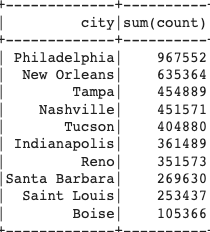

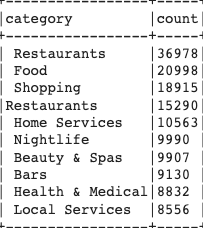

As we have explored our data, we found that 'Philadelphia' has most reviewed businesses and 'Restaurants' category is most reviewed. So we will try to build a recommender system trained on the reviewed restaurants in Philadelphia. 

We expect our system to recommend a user a restaurant according to his/her preferences in Philadelphia.

In [ ]:
# We found that business dataset has some columns which has missing values and do not add any value to our model

yelp_business = yelp_business.select('business_id','name', 'stars', 
                                 'review_count', 'attributes', 
                                 'categories', 'city').withColumnRenamed('stars', 'stars_restaurant')

yelp_business = yelp_business.filter((yelp_business['city'] == 'Philadelphia') & (yelp_business.categories.contains('Restaurants'))).drop('city')

In [ ]:
# We filter the business dataset and apply inner join it with review dataset to perform the factorization algorithm 
yelp_restaurant_review = yelp_review.select('*')
yelp_restaurant_review = yelp_restaurant_review.join(yelp_business, on='business_id', how='inner')
yelp_restaurant_review.select(['business_id', 'user_id', 'stars']).show(5)

**VISUALIZATIONS**

In [ ]:
# Plotting a histogram of frequency of star ratings of restaurants from review dataset
%matplotlib inline
reviews = yelp_restaurant_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]
plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='pink',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [ ]:
# Plotting a histogram of frequency of different star rating restaurants from the business dataset
restaurant_reviews = yelp_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]
plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='purple',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [ ]:
# Defining the categories of restaurants 
restaurant_categories = yelp_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]
print(restaurant_categories_list)

**WORDCLOUD**

In [ ]:
# Define words from review
word = " ".join(review for review in restaurant_categories_list)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# elimiminating some common words
text = word.replace('Restaurants', "")
text = word.replace('bars', "")
text = word.replace('New', "")
text = word.replace('Food', "")
text = word.replace('Planning', "")
text = word.replace('Arts', "")
text = word.replace('Entertainment', "")
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We find the words FOOD, AMERICAN, BREAKFAST and BRUNCH are maximum used words in the reviews

**BUILDING THE RECOMMENDER SYSTEM**

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType

In [ ]:
# Converting and transforming data into dataframe

indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(yelp_restaurant_review).transform(yelp_restaurant_review)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

In [ ]:
transformed.show(5)

**SPLIT THE DATA INTO TRAIN AND TEST DATASETS**

In [ ]:
# Split the data into train and test data sets in 80:20 ratio
(train, test) = transformed.randomSplit([0.8, 0.2])

In [ ]:
from heapq import nlargest
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext

In [ ]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.ml.recommendation import ALS
from pyspark import SparkContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [ ]:
# Building the system on ALS algorithm 

als = ALS(maxIter=5,
        regParam=0.09, 
        rank=25,
        userCol="user_id_index", 
        itemCol="business_id_index",
        ratingCol="stars", 
        coldStartStrategy="drop", 
        nonnegative=True)

recommender =als.fit(train)

To evaluate the recommender model, we use the metric Root Mean Square Error

In [ ]:
evaluator= RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions= recommender.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

**RESULTS OF RECOMMENDER SYSTEM**

Checking out the results of the system for a random user_id= 952

In [ ]:
test = recommender.recommendForAllUsers(20).filter(col('user_id_index')==952).select("recommendations").collect()
Restaurant_recm = []
for item in test[0][0]:        
    Restaurant_recm.append(item.business_id_index)
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(Restaurant_recm,IntegerType()).toDF("business_id_index")
transformed\
.select(['business_id', 'user_id', 'stars', 'categories'])\
.filter(col('user_id_index')==7313)\
.show()
restaurants\
.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'categories', 'name'])\
.drop_duplicates(subset=['name'])\
.show()
